In [1]:
from helpers import *
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
device = 'cuda' #I am using my gpu

transform = transforms.Compose([
    transforms.ToTensor(),
])
train_dataset = MNIST(root='../mnist_data', train=True, download=True, transform=transform)
img,_ = train_dataset[0]

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting ../mnist_data\MNIST\raw\train-images-idx3-ubyte.gz to ../mnist_data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting ../mnist_data\MNIST\raw\train-labels-idx1-ubyte.gz to ../mnist_data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting ../mnist_data\MNIST\raw\t10k-images-idx3-ubyte.gz to ../mnist_data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%

Extracting ../mnist_data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ../mnist_data\MNIST\raw



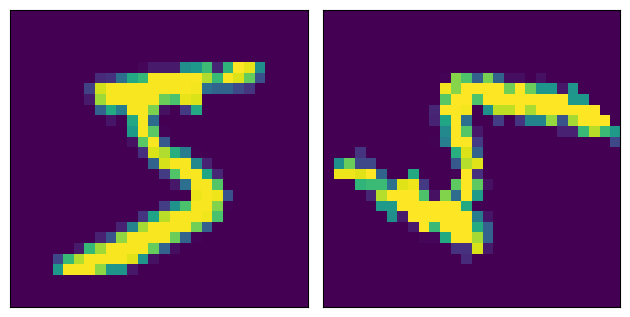

In [4]:
# testing with rotation
rotater = transforms.RandomRotation(degrees=(0,180))
rotated_img = rotater(img)
imgs = [img, rotated_img]
plot(imgs)

In [5]:
# Relabel and move
CR = img.to(device)
CT = rotated_img.to(device)

# Fine level of mesh - explodes the computational complexity the finer you go
gridsize = 200
# Creating the mesh and move
x = torch.stack(torch.meshgrid(
    torch.linspace(-1,1,gridsize), 
    torch.linspace(-1,1,gridsize)), dim=-1).reshape(-1,2).to(device)

# Approximating velocity function with neural network
input_dim = 3
hidden_dim = 32
output_dim = 2
v_net = VelocityFieldNN(input_dim, hidden_dim, output_dim).to(device)

# Adam optimizer works well with little tuning I have noticed
optimizer = optim.Adam(v_net.parameters(), lr=0.005)

num_epochs = 400
for epoch in range(num_epochs):
    optimizer.zero_grad()
    loss = loss_function(v_net, x, CR, CT, device)
    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch}, Loss: {loss.item()}")

/home/warin/miniconda3/envs/ml-env/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1702400440653/work/aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Epoch 0, Loss: 0.05998799949884415
Epoch 1, Loss: 0.056166909635066986
Epoch 2, Loss: 0.054210443049669266
Epoch 3, Loss: 0.05224406719207764
Epoch 4, Loss: 0.04992111772298813
Epoch 5, Loss: 0.047190360724925995
Epoch 6, Loss: 0.044295527040958405
Epoch 7, Loss: 0.04173753038048744
Epoch 8, Loss: 0.03959207236766815
Epoch 9, Loss: 0.037619367241859436
Epoch 10, Loss: 0.035794682800769806
Epoch 11, Loss: 0.03415277227759361
Epoch 12, Loss: 0.03247978910803795
Epoch 13, Loss: 0.03048308566212654
Epoch 14, Loss: 0.028360893949866295
Epoch 15, Loss: 0.02626093290746212
Epoch 16, Loss: 0.024239003658294678
Epoch 17, Loss: 0.022468145936727524
Epoch 18, Loss: 0.020710734650492668
Epoch 19, Loss: 0.01896636374294758
Epoch 20, Loss: 0.01758316345512867
Epoch 21, Loss: 0.016385527327656746
Epoch 22, Loss: 0.015350686386227608
Epoch 23, Loss: 0.014237884432077408
Epoch 24, Loss: 0.013195033185184002
Epoch 25, Loss: 0.01208015251904726
Epoch 26, Loss: 0.011088885366916656
Epoch 27, Loss: 0.01025

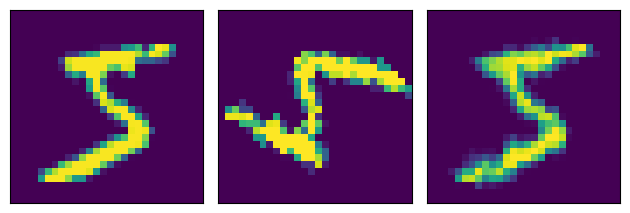

In [6]:
# now lets see what the transform is
# at this point v_net should be optimized

# move back to cpu
v_net = v_net.to('cpu')

# make the sampling grid the same size as CR and CT
gridsize = img.shape[1]
x = torch.stack(torch.meshgrid(
    torch.linspace(-1,1,gridsize),
    torch.linspace(-1,1,gridsize),
), dim=-1).reshape(-1,2)

# Solve the ODE
def odefunc(t, z):
    return v_net(z, t)
t = torch.tensor([0.0, 1.0]) 
z_T = odeint(odefunc, x, t)[-1] # Take the solution at t=1

# Solve the inverse ODE
def inv_odefunc(t, z):
    return -v_net(z, t)
z_inv_T = odeint(inv_odefunc, z_T, torch.flip(t, dims=[0]))[0] #take the solution at t=0
CT_z_inv_T = bilinear_interpolation(CT, z_inv_T, device='cpu').view(1, gridsize, gridsize).transpose(1,2)

imgs = [img, rotated_img, CT_z_inv_T]
# CR - CT - T(y(x))
plot(imgs)

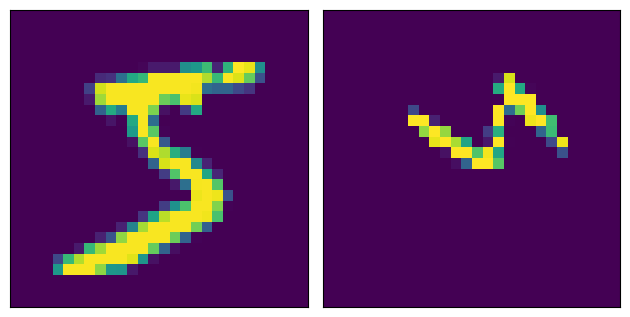

In [2]:
# Random affine transform
affine_transfomer = transforms.RandomAffine(degrees=(30, 70), translate=(0.1, 0.3), scale=(0.5, 0.75))
affine_img = affine_transfomer(img)
plot([img, affine_img])

In [3]:
# Relabel and move
CR = img.to(device)
CT = affine_img.to(device)

# Fine level of mesh - explodes the computational complexity the finer you go
gridsize = 200
# Creating the mesh and move
x = torch.stack(torch.meshgrid(
    torch.linspace(-1,1,gridsize), 
    torch.linspace(-1,1,gridsize)), dim=-1).reshape(-1,2).to(device)

# Approximating velocity function with neural network
input_dim = 3
hidden_dim = 32
output_dim = 2
v_net = VelocityFieldNN(input_dim, hidden_dim, output_dim).to(device)

# Adam optimizer works well with little tuning I have noticed
optimizer = optim.Adam(v_net.parameters(), lr=0.005)

num_epochs = 300
for epoch in range(num_epochs):
    optimizer.zero_grad()
    loss = loss_function(v_net, x, CR, CT, device)
    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch}, Loss: {loss.item()}")

c:\Users\smbm2\AppData\Local\miniconda3\envs\ml2-env\Lib\site-packages\torch\functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Epoch 0, Loss: 0.058450620621442795
Epoch 1, Loss: 0.05539355427026749
Epoch 2, Loss: 0.05290396511554718
Epoch 3, Loss: 0.05063862353563309
Epoch 4, Loss: 0.04878940433263779
Epoch 5, Loss: 0.049146637320518494
Epoch 6, Loss: 0.049215782433748245
Epoch 7, Loss: 0.048718176782131195
Epoch 8, Loss: 0.04833364859223366
Epoch 9, Loss: 0.04785708338022232
Epoch 10, Loss: 0.04736727476119995
Epoch 11, Loss: 0.04691638797521591
Epoch 12, Loss: 0.04656157270073891
Epoch 13, Loss: 0.04633283615112305
Epoch 14, Loss: 0.04622667282819748
Epoch 15, Loss: 0.046150557696819305
Epoch 16, Loss: 0.0460454560816288
Epoch 17, Loss: 0.04585370793938637
Epoch 18, Loss: 0.04560738429427147
Epoch 19, Loss: 0.04536506161093712
Epoch 20, Loss: 0.04531971365213394
Epoch 21, Loss: 0.045494042336940765
Epoch 22, Loss: 0.045624010264873505
Epoch 23, Loss: 0.0455930121243
Epoch 24, Loss: 0.04546045884490013
Epoch 25, Loss: 0.045331235975027084
Epoch 26, Loss: 0.045244231820106506
Epoch 27, Loss: 0.0451504699885845

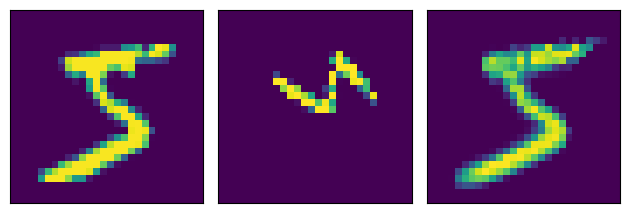

In [4]:

v_net = v_net.to('cpu')

# make the sampling grid the same size as CR and CT
gridsize = img.shape[1]
x = torch.stack(torch.meshgrid(
    torch.linspace(-1,1,gridsize),
    torch.linspace(-1,1,gridsize),
), dim=-1).reshape(-1,2)

# Solve the ODE
def odefunc(t, z):
    return v_net(z, t)
t = torch.tensor([0.0, 1.0]) 
z_T = odeint(odefunc, x, t)[-1] # Take the solution at t=1

# Solve the inverse ODE
def inv_odefunc(t, z):
    return -v_net(z, t)
z_inv_T = odeint(inv_odefunc, z_T, torch.flip(t, dims=[0]))[0] #take the solution at t=0
CT_z_inv_T = bilinear_interpolation(CT, z_inv_T, device='cpu').view(1, gridsize, gridsize).transpose(1,2)

imgs = [img, affine_img, CT_z_inv_T]
# CR - CT - T(y(x))
plot(imgs)

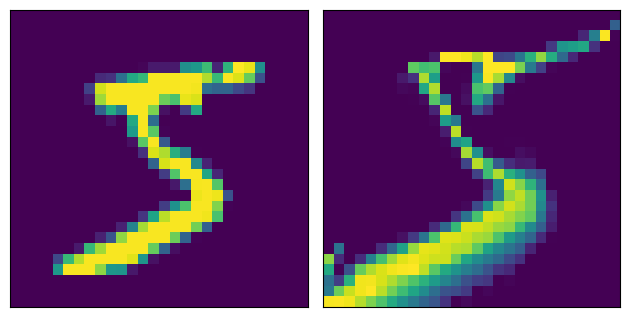

In [19]:
# Lets evaluate an different digit image to see what the transformation does to it
random_img, _ = train_dataset[0]

test_z = bilinear_interpolation(random_img, z_inv_T, device='cpu').view(1,28,28).transpose(1,2)

plot([random_img, test_z])